# Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
import matplotlib.dates as mdates
import pylab as plot

import seaborn as sns
import re
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.externals import joblib
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

import statsmodels.api as sm

from scipy import stats

c:\users\rared\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
params = {
    'legend.fontsize': "x-large",
     'figure.figsize': (15, 5),
     'axes.labelsize': 'x-large',
     'axes.titlesize': 20,
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large'
}
plot.rcParams.update(params)

In [3]:
def get_total_return(returns_df, costs_bps=[]):
    costs_bps = [ x*0.0005 for x in range(0, 5) ] if not costs_bps else costs_bps
    # get growth rate for all bps
    for cost in costs_bps:
        returns_df[f"return_growth_rate_{ int( cost * 10**4 ) }bps"] = np.where(
            returns_df["type"] == "long",
            (returns_df["close_price"] / returns_df["open_price"]) * (1 - cost) / (1 + cost),
            (returns_df["open_price"] / returns_df["close_price"]) * (1 - cost) / (1 + cost)
        )
    # aggregate over each position and its short/long-positions
    position_returns_df = (
        returns_df
        .groupby( ["position_num", "type"] )
        # multiply each 
        .agg(
            **{ f"total_return_{ int( cost * 10**4 ) }bps": (f"return_growth_rate_{ int( cost * 10**4 ) }bps", "prod") for cost in costs_bps }
        )
        # turn growth rate to 
        - 1
    )
#     # aggregate overeach position's total return
    return position_returns_df.groupby(level="type").agg("mean")

# Prepare Data

In [4]:
top10_1min_df = pd.read_csv(
    f"../data/1min/top10_2019_train_test.csv.gz",
    sep=',',
    parse_dates=["time"],
#     index_col=['time', 'pair'],
    infer_datetime_format=True,
    compression='gzip',
)
top10_1min_df.head()

filtered_1min_df = (
    top10_1min_df
    [ top10_1min_df[ f"volume_scaled"].shift(-1) != 0 ]
    .dropna()
)

In [5]:
filtered_1min_df.head()

,Unnamed: 0,time,open,close,high,low,volume,middle_median,pair,volume_scaled,...,cross_sectional_median_120min,cross_sectional_median_240min,cross_sectional_median_120min_long_15bps,cross_sectional_median_120min_short_15bps,cross_sectional_median_240min_long_15bps,cross_sectional_median_240min_short_15bps,future_2state_movement_120min,future_3state_movement_120min,future_2state_movement_240min,future_3state_movement_240min
1920,1920,2019-01-02 08:01:00,3924.6,3924.9,3924.9,3924.6,1.209678,3924.75,btcusd,0.489633,...,0.015303,0.019073,0.012261,-0.018022,0.016021,-0.021656,-1.0,1.0,-1.0,1.0
1921,1921,2019-01-02 08:02:00,3924.8,3924.8,3924.8,3924.8,0.049025,3924.80,btcusd,0.092626,...,0.015491,0.018899,0.012449,-0.018205,0.015847,-0.021488,-1.0,1.0,-1.0,1.0
1922,1922,2019-01-02 08:03:00,3924.8,3923.7,3924.8,3923.2,5.063342,3924.25,btcusd,0.737697,...,0.014694,0.019019,0.011655,-0.017433,0.015967,-0.021604,-1.0,1.0,-1.0,1.0
1923,1923,2019-01-02 08:04:00,3924.0,3924.9,3924.9,3923.6,1.211047,3924.45,btcusd,0.489843,...,0.012722,0.016779,0.009689,-0.015520,0.013733,-0.019448,-1.0,1.0,-1.0,1.0
1924,1924,2019-01-02 08:05:00,3924.9,3931.4,3931.4,3924.9,13.060967,3928.15,btcusd,0.871862,...,0.009605,0.014249,0.006581,-0.012481,0.011210,-0.017002,-1.0,0.0,-1.0,0.0


In [6]:
THRESHOLDS = [0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.85, 0.9, 0.95]
MODEL_NAMES = {"forest": "Random Forest", "logistic": "Logistic Regression",  "adaboost": "AdaBoost", "ann": "DNN",}
volume_specs = ["no_volume", "with_volume"]
targets = [
    "future_2state_movement_120min",
    "future_2state_movement_240min",
    "future_3state_movement_120min",
    "future_3state_movement_240min"
]
targets_2state = [
    "future_2state_movement_120min",
    "future_2state_movement_240min",
#     "future_3state_movement_120min",
#     "future_3state_movement_240min"
]
model_names = {
    "logistic": "Logistic Regression",
    "forest": "Random Forest",
    "adaboost": "AdaBoost",
    "ann": "Deep Neural Network",
}

In [7]:
x_columns = [ col for col in  top10_1min_df.columns if "middle_return" in col and "future" not in col ]
x_columns_volume = [ col for col in  top10_1min_df.columns if ("middle_return" in col or "volume_scaled" in col) and "future" not in col ]
feature_selections = {
    "no_volume": x_columns,
    "with_volume": x_columns_volume,
}

In [ ]:
trading_returns_df = pd.DataFrame()
for model_name in MODEL_NAMES:
    for threshold in THRESHOLDS:
#         for volume_spec in ["with_volume", "no_volume"]:
        for volume_spec in feature_selections:
            for target in targets_2state:
                try:
                    filename = f"../results/{model_name}/returns/trading_returns_{volume_spec}_{target}_{round(threshold*100, 1)}_threshold.csv"
                    df = pd.read_csv(filename)
                    df["volume_spec"] = volume_spec
                    df["threshold"] = threshold
                    df["model"] = model_name
                    df["target"] = target
                    trading_returns_df = pd.concat([trading_returns_df, df])
                    
                    print(model_name, threshold, volume_spec, target)
                except:
                    print("EXCEPTION:", filename)
#     trading_returns_df.to_csv(f"../results/{model_name}/returns/{model_name}_trading_returns_future_2state_movement.csv", index=False)
trading_returns_df.head()    
# trading_returns_df.to_csv(f"../results/trading_returns_future_2state_movement_120min.csv", index=False)        

Add short-/long-return for different transaction costs

In [ ]:
costs_bps = [ x*0.0005 for x in range(0, 5) ]
# get growth rate for all bps
for cost in costs_bps:
    trading_returns_df[f"return_growth_rate_{ int( cost * 10**4 ) }bps"] = np.where(
        trading_returns_df["type"] == "long",
        (trading_returns_df["close_price"] / trading_returns_df["open_price"]) * (1 - cost) / (1 + cost),
        (trading_returns_df["open_price"] / trading_returns_df["close_price"]) * (1 - cost) / (1 + cost),
    )
print(trading_returns_df.shape)    
trading_returns_df.head()    

# Threshold vs Return

## Total return for spec combination and model

In [ ]:
def total_returns_by_threshold(returns_df, title="Total returns for different probabiltiy thresholds and basis-points", volume_spec="no", xlim=0.63):
    df = returns_df[ returns_df["volume_spec"] == volume_spec]
    max_return = round(df["total_return_15bps"].max() * 100, 2)
    max_return_threshold = df["threshold"][df["total_return_15bps"].argmax()]
    columns_mapping = { "total_return_5bps": "5bps", "total_return_10bps": "10bps", "total_return_15bps": "15bps", "total_return_20bps": "20bps" }
    ax = (
        df
        .rename(columns=columns_mapping)
        .plot(
            x="threshold", 
            y=["5bps", "10bps", "15bps", "20bps"],
            figsize=(20, 10), 
        )
    )   
    ax.set_xlim(right=xlim)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_title(f"{title}\n Max total return: {max_return}% (@ threshold: {max_return_threshold}, cost: 15bps)")
    ax.set_ylabel("Return")
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
    ax.set_xlabel("Threshold")    
    return ax

In [ ]:
agg_returns_df = (
    (
        (   
            # get total return per individual trading simulation
            trading_returns_df
            .groupby(["model", "volume_spec", "target", "threshold", "position_num", "type" ])
            .agg(
                { f"return_growth_rate_{int( cost * 10**4 )}bps": "prod" for cost in costs_bps }
            )
            .reset_index()
        )
        # get mean return per position type
        .groupby(["model", "volume_spec", "target", "threshold", "type"])
        .agg(
                { f"return_growth_rate_{int( cost * 10**4 )}bps": "mean" for cost in costs_bps }
        )
        .reset_index()
    )
    # mean return per threshold
    .groupby(["model", "volume_spec", "target", "threshold",])
    .agg(
            **{ f"{int( cost * 10**4 )}bps": (f"return_growth_rate_{int( cost * 10**4 )}bps", "mean") for cost in costs_bps }
    )
    -1
).reset_index()
# print(agg_returns_df[ agg_returns_df["model"] == "forest" ]["open_time"].max())
agg_returns_df["target"] = agg_returns_df["target"].str.replace("future_2state_movement_", "")
agg_returns_df["volume_spec"] = agg_returns_df["volume_spec"].str.replace("_", " ")
agg_returns_df["model"] = agg_returns_df["model"].map(MODEL_NAMES)
agg_returns_df.head()

In [ ]:
for volume_spec in agg_returns_df["volume_spec"].unique():
    for target in agg_returns_df["target"].unique():
        df = agg_returns_df[ 
             (agg_returns_df["volume_spec"] == volume_spec) 
            & (agg_returns_df["target"] == target) 
        ]
        ax = sns.lineplot(x="threshold", y="15bps", hue="model", data=df)
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_title(f"Total returns at different thresholds at 15bps ({volume_spec}, {target})")
        ax.set_ylabel("Return")
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
        ax.set_xlabel("Threshold")  
#         plt.show()
#         plt.draw()
        plt.savefig(f"../results/_general/all_threshold_vs_return_15bps_{volume_spec}_{target}.png")
        plt.clf()

## Max returns at best threshold

In [ ]:
agg_returns_df = (
    (
        (   
            # get total return per individual trading simulation
            trading_returns_df
            .groupby(["model", "volume_spec", "target", "threshold", "position_num", "type" ])
            .agg(
                { f"return_growth_rate_{int( cost * 10**4 )}bps": "prod" for cost in costs_bps }
            
            )
            .reset_index()
        )
        # get mean return per position type
        .groupby(["model", "volume_spec", "target", "threshold", "type"])
        .agg(
                { f"return_growth_rate_{int( cost * 10**4 )}bps": "mean" for cost in costs_bps }
        )
        .reset_index()
    )
    # mean return per threshold
    .groupby(["model", "volume_spec", "target", "threshold",])
    .agg(
            **{ f"{int( cost * 10**4 )}bps": (f"return_growth_rate_{int( cost * 10**4 )}bps", "mean") for cost in costs_bps }
    )
    -1
).reset_index()

In [ ]:
max_agg_returns_df = (
    agg_returns_df
    .set_index("threshold")
    .groupby(["model", "volume_spec", "target"])
    .agg(
        max_return_15bps=("15bps", "max"),
        max_return_threshold=("15bps", "idxmax"),
    )
    .reset_index()
)
max_agg_returns_df

In [ ]:
print(trading_returns_df.shape)
agg_max_threshold_df =  pd.merge(
    trading_returns_df, 
    max_agg_returns_df, 
    on=["model", "volume_spec", "target"],
    how="left"
)
print(agg_max_threshold_df.shape)
agg_max_threshold_df

In [ ]:
(
    agg_max_threshold_df
    [ agg_max_threshold_df["threshold"] == agg_max_threshold_df["max_return_threshold"] ]
    .groupby(["model", "volume_spec", "target",  "position_num", "type" ])
    .agg(
        trade_count=("max_return_15bps", "count")
    )
    .reset_index()
)

In [ ]:
# total trades
best_spec_trade_count_df = (
    (
        (   
            # get total trades per individual trading simulation, only for respective max threshold
            agg_max_threshold_df
            [ agg_max_threshold_df["threshold"] == agg_max_threshold_df["max_return_threshold"] ]
            .groupby(["model", "volume_spec", "target",  "position_num", "type" ])
            .agg(
                trade_count=("max_return_15bps", "count")
            )
            .reset_index()
        )
        # get mean number of trades per type
        .groupby(["model", "volume_spec", "target", "type"])
        .agg(
            trade_count=("trade_count", "mean")
        )
        .reset_index()
    )
    # mean return per spec
    .groupby(["model", "volume_spec", "target",])
    .agg(
        trade_count=("trade_count", "mean")
    )
).reset_index()
best_spec_trade_count_df

In [ ]:
max_returns_df = (
    pd.merge(
        max_agg_returns_df, 
        best_spec_trade_count_df,
        on=["model", "volume_spec", "target"],
    )
    .set_index(["model", "volume_spec", "target"])

)
max_returns_df

In [ ]:
# max_returns_df.to_excel("../results/_general/max_agg_returns.xlsx")
# max_returns_df.to_csv("../results/_general/max_agg_returns.csv")

## Plot each return for model run at different transaction costs

In [ ]:
agg_returns_df = (
    (
        (   
            # get total return per individual trading simulation
            trading_returns_df
            .groupby(["model", "volume_spec", "target", "threshold", "position_num", "type" ])
            .agg(
                { f"return_growth_rate_{int( cost * 10**4 )}bps": "prod" for cost in costs_bps }
            )
            .reset_index()
        )
        # get mean return per position type
        .groupby(["model", "volume_spec", "target", "threshold", "type"])
        .agg(
                { f"return_growth_rate_{int( cost * 10**4 )}bps": "mean" for cost in costs_bps }
        )
        .reset_index()
    )
    # mean return per threshold
    .groupby(["model", "volume_spec", "target", "threshold",])
    .agg(
            **{ f"{int( cost * 10**4 )}bps": (f"return_growth_rate_{int( cost * 10**4 )}bps", "mean") for cost in costs_bps }
    )
    -1
).reset_index()
agg_returns_df

In [ ]:
x_lims = [0.63, 0.63, 0.56]
# x_lims = [None, None, None, None]

# for model_name, xlim in zip(MODEL_NAMES, x_lims):
for model_name in agg_returns_df["model"].unique():
    for volume_spec in agg_returns_df["volume_spec"].unique():
        for target in agg_returns_df["target"].unique():
            print(model_name, volume_spec, target)
            df = agg_returns_df[ 
                (agg_returns_df["model"] == model_name) 
                & (agg_returns_df["volume_spec"] == volume_spec) 
                & (agg_returns_df["target"] == target) 
            ]
            max_return = round(df["15bps"].max() * 100, 2)
            max_return_threshold = df["threshold"][ df["15bps"].idxmax() ]
            ax = df.plot(
                    x="threshold", 
                    y=["5bps", "10bps", "15bps", "20bps"],
                )
    #         ax.set_xlim(right=xlim)
            ax.axhline(y=0, color='r', linestyle='--')
            ax.set_title(f"{MODEL_NAMES[model_name]} ({volume_spec.replace('_', ' ')}, {target.replace('future_2state_movement_', '')})\n Max total return for 15bps: {max_return}% (threshold: {max_return_threshold})")
            ax.set_ylabel("Return")
            ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
            ax.set_xlabel("Threshold")      
            plt.savefig(f"../results/{model_name}/plots/{model_name}_total_returns_by_thresholds.png")

Notes (19.07.2020):
- For Random Forest (no volume, 240min) results are off -> rerun trading

In [ ]:
# ax = sns.lineplot(x = "threshold", y = "total_return_15bps", data = trading_returns_df.groupby(["model", "volume_spec", "threshold"]).mean().reset_index(), 
#              hue = "model")
# ax.set_xlabel("Threshold")
# ax.set_ylabel("Return")
# ax.set_title("Returns at 30bps for different thresholds")
# ax.axhline(y=0, color='r', linestyle='--')
# ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
# # plt.savefig("../results/threshold_vs_returns_at_30bps.png")

# Correct classifications, but insufficient returns

In [ ]:
trading_returns_df.head()

In [ ]:
trading_returns_df["insufficient_long_return"] = np.where(
    (trading_returns_df["type"] == "long")
    &  ( 0 < trading_returns_df["close_return"] ) 
    & ( trading_returns_df["return_growth_rate_15bps"] < 1 ) ,
    1,
    0,
)

trading_returns_df["insufficient_short_return"] = np.where(
    (trading_returns_df["type"] == "short")
    &  ( 0 > trading_returns_df["close_return"] ) 
    & ( trading_returns_df["return_growth_rate_15bps"] < 1 ) ,
    1,
    0,
)
trading_returns_df["insufficient_return"] = np.where(
    (trading_returns_df["insufficient_short_return"] == 1) | (trading_returns_df["insufficient_long_return"] == 1),
    1,
    0,
)

In [ ]:
count_returns_df = (
    (
        (   
            # get number trades for individual positions
            trading_returns_df
            .groupby(["model","volume_spec", "target", "threshold", "type", "position_num"])
            .agg(
                total_trades=("return_growth_rate_0bps", "count")
            )
#             .reset_index()
        )
        # aggregate over type
#         .groupby(["model","volume_spec", "target", "threshold", "type",])
#         .agg(
#             mean_total_trades=("total_trades", "mean")
#         )
#         .reset_index()
            # get number trades for individual positions
    )        
        
)

count_returns_df

In [ ]:
low_returns_df = (
    (
        trading_returns_df[ trading_returns_df["insufficient_return"] == 1 ]
        .groupby(["model", "volume_spec", "target", "threshold", "type", "position_num"])
        .agg(
            total_trades=("return_growth_rate_15bps", "count")
        )
    
    )
#     .reset_index()
)
low_returns_df

In [ ]:
low_returns_proportion_df = low_returns_df / count_returns_df
low_returns_proportion_df = (
    low_returns_proportion_df
    .groupby(["model", "volume_spec", "target", "threshold", "type",])
    .mean()
    .reset_index()
)
low_returns_proportion_df

In [ ]:
# low_returns_proportion_df["target"] = low_returns_proportion_df["target"].str.replace("future_2state_movement_", "")
# low_returns_proportion_df["volume_spec"] = low_returns_proportion_df["volume_spec"].str.replace("_", " ")
# low_returns_proportion_df["model"] = low_returns_proportion_df["model"].map(MODEL_NAMES)

In [ ]:
for position_type in low_returns_proportion_df["type"].unique():
    for spec in low_returns_proportion_df["volume_spec"].unique():
        for target in low_returns_proportion_df["target"].unique():

            ax = sns.lineplot(
                x='Threshold', 
                y='Proportion Insufficient Returns', 
                hue='Model', 
                data=(
                    low_returns_proportion_df[
                        (low_returns_proportion_df["volume_spec"] == volume_spec)
                        & (low_returns_proportion_df["target"] == target)
                        & (low_returns_proportion_df["type"] == position_type)
                        & (low_returns_proportion_df["model"] != "adaboost")
                    ]
    #                     [ low_returns_df.index.get_level_values("threshold") <= 0.6 ]
                    .reset_index()
                    .rename(columns={
                         "threshold": "Threshold",
                         "total_trades": "Proportion Insufficient Returns",
                         "model": "Model",
                        }
                   )
                ),
            )
            ax.set_xlim((0.5, 0.6))
            ax.set_title(f"Proportion of insufficient returns at 15bps transaction cost per threshold ({position_type}, {spec}, {target})")
            ax.set_xlabel("Threshold")
            ax.set_ylabel("Proportion Insufficient Returns")
            ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
            plt.show()
            plt.clf()
    # plt.savefig("../results/proportion_insufficient_returns.png")

In [ ]:
for position_type in low_returns_proportion_df["type"].unique():
    for spec in low_returns_proportion_df["volume_spec"].unique():
        for model in low_returns_proportion_df["model"].unique():

            ax = sns.lineplot(
                x='Threshold', 
                y='Proportion Insufficient Returns', 
                hue='target', 
                data=(
                    low_returns_proportion_df[
                        (low_returns_proportion_df["volume_spec"] == volume_spec)
                        & (low_returns_proportion_df["model"] == model)
                        & (low_returns_proportion_df["type"] == position_type)
                    ]
    #                     [ low_returns_df.index.get_level_values("threshold") <= 0.6 ]
                    .reset_index()
                    .rename(columns={
                         "threshold": "Threshold",
                         "total_trades": "Proportion Insufficient Returns",
                         "model": "Model",
                        }
                   )
                ),
            )
            ax.set_xlim((0.5, 0.6))
            ax.set_title(f"Proportion of insufficient returns at 30bps transaction cost per threshold for {model} \n ({position_type}, {spec}, {target})")
            ax.set_xlabel("Threshold")
            ax.set_ylabel("Proportion Insufficient Returns")
            ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
            plt.show()
            plt.clf()
    # plt.savefig("../results/proportion_insufficient_returns.png")

# Trading Decisions

## Traded Pairs

In [ ]:
trading_returns_df.columns

In [ ]:
trading_returns_df.head()

In [ ]:
max_pair_count_df = (
    (
        (
            trading_returns_df
            [ trading_returns_df["threshold"] == 0.5 ]
            .groupby(["model", "volume_spec", "target", "position_num", "type", "pair"])
            .agg(
                pair_count=("close_price", "count"),
            )
            .reset_index()
        )
        .groupby(["model", "volume_spec", "target", "type", "pair"])
        .agg(
            pair_count=("pair_count", "mean"),
        )
        .reset_index()    
    )
    .set_index("pair")
    .groupby(["model", "volume_spec", "target", "type"])
    .agg(
        max_pair_count=("pair_count", "max"),
        max_pair=("pair_count", "idxmax"),
    )
    .reset_index()   
)
# max_pair_count_df = max_pair_count_df[ max_pair_count_df["max_pair_count"] > 10]
max_pair_count_df

In [ ]:
# max_pair_count_df.set_index(["model", "volume_spec", "target",  "type"]).unstack(level=-1).to_excel("../results/max_pair_count.xlsx")

## Number of Trades

In [ ]:
trade_count_df = (
    (
        (
            trading_returns_df
            [ trading_returns_df["threshold"] == 0.5 ]
            .groupby(["model", "volume_spec", "target",  "position_num", "type"])
            .agg(
                trade_count=("close_price", "count"),
            )
            .reset_index()
        )
        .groupby(["model", "volume_spec", "target", "type", ])
        .agg(
            mean_trade_count=("trade_count", "mean"),
            std_trade_count=("trade_count", "std"),
        )
        .reset_index()    
    )
    .set_index(["model", "volume_spec", "target", "type"])
    .unstack(level="type")
#     .set_index("pair")
#     .groupby(["model", "volume_spec", "target", "threshold", "type"])
#     .agg(
#         max_pair_count=("pair_count", "max"),
#         max_pair=("pair_count", "idxmax"),
#     )
#     .reset_index()   
)
trade_count_df["long_short_diff"] = trade_count_df["mean_trade_count"]["long"] - trade_count_df["mean_trade_count"]["short"]
# trade_count_df = trade_count_df[ 
#     (trade_count_df["mean_trade_count"]["long"] > 15)
#     & (trade_count_df["mean_trade_count"]["short"] > 15)
# ]
trade_count_df

In [ ]:
trade_count_df[["long_short_diff"]].unstack(level="target")
#.to_excel("../results/trade_pair_count.xlsx")

# Returns statistics

In [ ]:
agg_returns_df = (
    (
        (   
            trading_returns_df
            [ (trading_returns_df["threshold"] == 0.6) 
             & (trading_returns_df["model"] != "adaboost") 
            ]
            .groupby(["model", "volume_spec", "target", "type", "position_num",])
            .agg(
                return_growth_rate_15bps=("return_growth_rate_15bps", "prod"),
                return_growth_rate_15bps_mean=("return_growth_rate_15bps", "mean"),
                return_growth_rate_15bps_std=("return_growth_rate_15bps", "std"),
            )
            .reset_index()
        )
            .groupby(["model", "volume_spec", "target", "type"])
            .mean()
    )
#     .groupby(["model", "volume_spec", "target", pd.Grouper(key='open_time', freq='D')])
#     .agg(daily_return_15bps=("return_growth_rate_15bps", "mean"))
#     -1
).reset_index()

agg_returns_df

# Training Evaluation

## Model Accuracy

In [ ]:
filtered_1min_df.head()

In [ ]:
accuracy_scores = list()
for target in targets_2state:
    for features_spec, x_columns in feature_selections.items():  
        # train
        x_train = filtered_1min_df[ filtered_1min_df["time"] < "2019-11-01" ][x_columns]
        y_train = filtered_1min_df[ filtered_1min_df["time"] < "2019-11-01" ][target]                        
        # test
        x_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ][x_columns]
        y_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ][target]            
#         for model_name, model_fullname in {"ann": "Deep Neural Network"}.items():
        for model_name, model_fullname in MODEL_NAMES.items():
            print(f"../models/{model_name}/{model_name}_{features_spec}_{target}.pkl")
            try:
                clf = joblib.load(f"../models/{model_name}/{model_name}_{features_spec}_{target}.pkl")
                # train
                # accuracy scores
                accuracy_train = clf.score( x_train, y_train)
                accuracy_test = clf.score( x_test, y_test)
                accuracy_scores.append({
                    "model": model_name,
                    "feature_selection": features_spec,
                    "target": target,
                    "accuracy_train": accuracy_train,
                    "accuracy_test": accuracy_test,                
                })
            except:
                print("EXCEPTION")
accuracy_scores

In [ ]:
accuracies_df = (
    pd.DataFrame(accuracy_scores)
    .sort_values(by=["model", "feature_selection", "target"])
    
)
accuracies_df["feature_selection"] = accuracies_df["feature_selection"].str.replace("_", " ")
accuracies_df["target"] = accuracies_df["target"].str.replace("future_2state_movement_", "")
accuracies_df = accuracies_df.set_index(["model", "feature_selection", "target"])
accuracies_df

In [ ]:
accuracies_df = pd.read_csv("../results/accuracy_train_test.csv")
# accuracies_df = (
#     accuracies_df
#     [ accuracies_df["model"] != "ann" ]
# )
accuracies_df = (
    pd.concat([accuracies_df, accuracy_scores_df], ignore_index=False)
    .sort_values(by=["model", "feature_selection", "target"])
)
accuracies_df

In [ ]:
accuracies_df["feature_selection"] = accuracies_df["feature_selection"].str.replace("_", " ")
accuracies_df["target"] = accuracies_df["target"].str.replace("future_2state_movement_", "")
accuracies_df

In [ ]:
# accuracy_scores_df = (
#     pd.concat([accuracy_scores_df, ann_accuracy_scores_df], ignore_index=False)
#     .sort_values(by=["model", "feature_selection", "target"])
# )
# accuracy_scores_df.head()

In [ ]:
accuracies_df.to_excel("../results/accuracy_train_test.xlsx", sheet_name='accuracy')

## ROC

In [ ]:
top10_1min_df = pd.read_csv(
    f"../data/1min/top10_2019_train_test.csv.gz",
    sep=',',
    parse_dates=["time"],
    index_col=['time', 'pair'],
    infer_datetime_format=True,
    compression='gzip',
)
top10_1min_df.head()

filtered_1min_df = (
    top10_1min_df
    [ top10_1min_df[ f"volume_scaled"].shift(-1) != 0 ]
    .dropna()
)

In [ ]:
models = ["logistic", "forest"]
model_names = {
    "logistic": "Logistic Regression",
    "forest": "Random Forest",
    "adabost": "AdaBoost",
}
x_columns = [ col for col in  top10_1min_df.columns if "return" in col and "future" not in col ]
target = ["future_2state_movement_120min"]
# ["logistic", "forest", ]
x_test = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") >= "2019-11-01") ][x_columns]
y_test = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") >= "2019-11-01") ][target]   

In [ ]:
for model_name, model_fullname in MODEL_NAMES.items():
    print(model_fullname)
    for target in ["future_2state_movement_120min"]:     
        x_test = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") >= "2019-11-01") ][x_columns]
        y_test = filtered_1min_df[ (filtered_1min_df.index.get_level_values("time") >= "2019-11-01") ][target]            
        # get predictions
        clf = joblib.load(f"../models/{model_name}/{model_name}_no_volume_{target}.pkl")
        predictions = clf.predict_proba( x_test )
        
        y_pred_proba = clf.predict_proba(x_test)[::,1]
        fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f"AUC={ round(auc, 4) }")
        plt.title(f"ROC-Curve for {model_fullname}")
        plt.legend(loc=4)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.tight_layout()
        # draw diagonal
        ident = [0.0, 1.0]
        plt.plot(ident , ident, ls="--", color="red")
        plt.show()
        plt.savefig(f"../results/{model_name}/plots/roc-curve.png")
        plt.clf()

## Precision and Recall

In [ ]:
def plot_prec_recall_vs_tresh(y_test, y_scores, count=True, title="Precision and Recall for different Thresholds", xlim=(0.5, 0.625)):
    fig, ax = plt.subplots()
    prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1], )
    ax.plot(tre, prec[:-1], 'b--', label='precision')
    ax.plot(tre, rec[:-1], 'g--', label = 'recall')
    ax.set_xlabel('Threshold')
#     ax.legend(loc='upper right')    
    ax.set_ylim([0,1])
#     ax.set_xlim(xlim)
    ax.set_title(title)
    if count:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        x_thresholds = np.linspace(0.5, max(tre), num=100)
        y_prob_count = list()
        for threshold in x_thresholds:
            y_prob_count.append( len([ x for x in (y_scores[:,1] > threshold) if x]) ) 
        color = 'tab:red'
        ax2.set_ylabel('Count')  # we already handled the x-label with ax1
        ax2.plot(x_thresholds, y_prob_count, color=color, label='positive-classifications')
#         ax2.legend(loc='upper right')  
        ax2.set_yscale("log")
        ax2.tick_params(axis='y')
#         ax2.set_xlim(xlim)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        fig.legend(loc="upper right", 
                   bbox_to_anchor=(1, 0.6), 
                   bbox_transform=ax.transAxes)
        return fig, ax, ax2
    return fig, ax

In [ ]:
# for test set
for model_name, model_fullname in MODEL_NAMES.items():
    print(model_fullname)
    for target in targets_2state:     
        for volume_spec, columns in feature_selections.items():
            print(model_name, target, volume_spec)
            x_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ][columns]
            y_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ][target]    
            clf = joblib.load(f"../models/{model_name}/{model_name}_{volume_spec}_{target}.pkl")
            y_scores = clf.predict_proba(x_test)
#             prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1], )    
            fig, *_ = plot_prec_recall_vs_tresh(
                y_test, 
                y_scores, 
                title=f"Precision and Recall for different thresholds for {model_fullname} ({volume_spec.replace('_', ' ')}, {target.replace('future_2state_movement_', '')})",
                count=True,
            )
            plt.savefig(f"../results/{model_name}/plots/{model_name}_{volume_spec}_{target}_precision_vs_threshold.png") 
            plt.clf()

In [ ]:
# training set
for model_name, model_fullname in MODEL_NAMES.items():
    print(model_fullname)
    for target in targets_2state:     
        for volume_spec, columns in feature_selections.items():
            print(model_name, target, volume_spec)
            x_train = filtered_1min_df[ (filtered_1min_df["time"] < "2019-11-01") ][columns]
            y_train = filtered_1min_df[ (filtered_1min_df["time"] < "2019-11-01") ][target]    
            clf = joblib.load(f"../models/{model_name}/{model_name}_{volume_spec}_{target}.pkl")
            y_scores = clf.predict_proba(x_train)
            fig, *_ = plot_prec_recall_vs_tresh(
                y_train, 
                y_scores, 
                title=f"Precision and Recall on training set for different thresholds for {model_fullname} ({volume_spec.replace('_', ' ')}, {target.replace('future_2state_movement_', '')})",
                count=True,
            )
            plt.savefig(f"../results/{model_name}/plots/train_{model_name}_{volume_spec}_{target}_precision_vs_threshold.png") 

# Return over time

## Cumulative Portfolio Return

In [ ]:
top10_ohlc_df = pd.read_csv(
    f"../data/1min/top10_merged.csv.gz",
    sep=',',
    parse_dates=["time"],
#     index_col=['time', 'pair'],
    infer_datetime_format=True,
    compression='gzip',
)
top10_ohlc_df.head()

In [ ]:
top10_ohlc_df = top10_ohlc_df[ (top10_ohlc_df["time"] >= "2019-11-01") & (top10_ohlc_df["time"] < "2020-01-01")]
top10_ohlc_df.head()

In [ ]:
top10_ohlc_df.shape

In [ ]:
pf_returns_df = (
    top10_ohlc_df
    .sort_values(["pair", "time"])
    .groupby([
        pd.Grouper(key="pair"),
        pd.Grouper(key="time", freq="Y")
    ])
    .agg(
        first_price=("middle_median", "first"),
        last_price=("middle_median", "last"),
    )
    .reset_index()
)

pf_returns_df["long_growth"] = pf_returns_df["last_price"] / pf_returns_df["first_price"]
pf_returns_df["short_growth"] = pf_returns_df["first_price"] / pf_returns_df["last_price"]

pf_returns_df

In [ ]:
(
    pf_returns_df
    .agg({"short_growth": "mean"})
    - 1
)

In [ ]:
pf_daily_returns_df = (
    top10_ohlc_df
    .sort_values(["pair", "time"])
    .groupby([
        pd.Grouper(key="pair"),
        pd.Grouper(key="time", freq="D")
    ])
    .agg(
        first_price=("middle_median", "first"),
        last_price=("middle_median", "last"),
    )
    
).reset_index()

pf_daily_returns_df["long_growth"] = pf_daily_returns_df["last_price"] /  pf_daily_returns_df["first_price"]
pf_daily_returns_df["short_growth"] = pf_daily_returns_df["first_price"] /  pf_daily_returns_df["last_price"]

pf_daily_returns_df

In [ ]:
pf_daily_returns_df[["long_growth_cum", "short_growth_cum"]] = (
    pf_daily_returns_df
    .groupby("pair")
    .cumprod()
    [["long_growth", "short_growth"]]
)
 
    
pf_daily_returns_df[["long_return_cum", "short_return_cum"]] = pf_daily_returns_df[["long_growth_cum", "short_growth_cum"]] - 1
pf_daily_returns_df[[]].mean(axis=1)

pf_daily_returns_df["model"] = "equal-weight-pf"

In [ ]:
pf_daily_returns_df.head()

In [ ]:
pf_daily_returns_plot_df = pf_daily_returns_df.copy()
pf_daily_returns_plot_df = pf_daily_returns_plot_df.rename(columns={
    "pair": "Pair",
    "short_return_cum": "Cumulative return",
    "time": "Date",
})
pf_daily_returns_plot_df["Pair"] = pf_daily_returns_plot_df["Pair"].str.upper()
pf_daily_returns_plot_df["Pair"] = pf_daily_returns_plot_df["Pair"].str.replace("USD", "/USD")


ax = sns.lineplot(x="Date", y="Cumulative return", hue="Pair", 
                  data=pf_daily_returns_plot_df)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.axhline(y=0, color='r', linestyle='--')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d.%m"))
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Return")
ax.set_title("Daily cumulative short returns in the trading period")
plt.savefig("../results/all_top_10_daily_cum_returns.png", bbox_inches='tight')

In [ ]:
pf_daily_returns_df = (
    pf_daily_returns_df
    .groupby("time")
    .mean()
    [["long_return_cum", "short_return_cum"]]
    .reset_index()
)
pf_daily_returns_df.head()

In [ ]:
pf_daily_returns_df["time"].values[-1]

In [ ]:
ax = sns.lineplot(x="time", y="short_return_cum", data=pf_daily_returns_df)

ax.axhline(y=0, color='r', linestyle='--')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d.%m"))
ax.set_title("Daily cumulative short equal-weight portfolio returns")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Returns")
ax.annotate(
    f'{round(pf_daily_returns_df["short_return_cum"].values[-1]*100, 2)}%',
    xy=(mdates.date2num(pf_daily_returns_df["time"].values[-1]) - 1.75,
        pf_daily_returns_df["short_return_cum"].values[-1] + 0.02),
    fontsize=15,
)
ax.plot( pf_daily_returns_df["time"].values[-1], pf_daily_returns_df["short_return_cum"].values[-1], 'bo')
# plt.savefig("../results/equal_weight_pf_daily_returns.png")

## Simple Daily Returns Models vs Portfolio

In [ ]:
trading_returns_df.head()

In [ ]:
trading_returns_df["open_time"] = pd.to_datetime(trading_returns_df["open_time"], infer_datetime_format=True)

In [ ]:
trading_returns_df.head()

In [ ]:
max_agg_return_df = pd.read_csv("../results/_general/max_agg_returns.csv")
max_agg_return_df

In [ ]:
pd.merge( [trading_returns_df, max_agg_return_df], on=["model", "volume_spec", "target"], how="left")

In [ ]:
agg_returns_df = (
    (
        (   
            trading_returns_df
            [ ( (trading_returns_df["threshold"] == 0.6) & (trading_returns_df["model"] == "adaboost") & (trading_returns_df["model"] == "adaboost") ) 
             |   
            ]
            .groupby(["model", "volume_spec", "target", "type", "position_num", pd.Grouper(key='open_time', freq='D')])
            .agg({"return_growth_rate_15bps": "prod"})
            .reset_index()
        )
            .groupby(["model", "volume_spec", "target", "type", pd.Grouper(key='open_time', freq='D')])
            .mean()
            .reset_index()
    )
    .groupby(["model", "volume_spec", "target", pd.Grouper(key='open_time', freq='D')])
    .agg(daily_return_15bps=("return_growth_rate_15bps", "mean"))
    -1
).reset_index()

agg_returns_df.head()

In [ ]:
for spec in agg_returns_df["volume_spec"].unique():
    for target in agg_returns_df["target"].unique():
        df = agg_returns_df[
            (agg_returns_df["volume_spec"] == spec)
            & (agg_returns_df["target"] == target)
        ]
        ax = sns.lineplot(x="open_time", y="daily_return_15bps", hue="model", 
                          data=df)
        ax.axhline(y=0, color='r', linestyle='--')
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d.%m"))
        ax.set_title(f"Daily mean returns in the trading period for {spec}, {target}")
        plt.show()
        plt.clf()
    # plt.savefig("../results/all_dailymean_returns.png")

##  Daily Cumulative Model Returns

In [ ]:
cum_returns_df = ( 
    trading_returns_df
    [ (trading_returns_df["threshold"] == 0.6) 
     & (trading_returns_df["model"] != "adaboost") 
    ]
    .groupby(["model", "volume_spec", "target", "type", "position_num", pd.Grouper(key='open_time', freq='D')])
    .agg({"return_growth_rate_15bps": "prod"})
    .reset_index()
)
cum_returns_df.head()

In [ ]:
cum_returns_df["cumulative_growth_15bps"] = (
    cum_returns_df
    .groupby(["model", "volume_spec", "target", "type", "position_num",])
    .cumprod()
    ["return_growth_rate_15bps"]
)
cum_returns_df.head()

In [ ]:
cum_returns_df = (
    (
        cum_returns_df
        .groupby(["model", "volume_spec", "target", "type", "open_time"])
        .agg(
            return_15bps= ("return_growth_rate_15bps", "mean"),
            cumulative_return_15bps= ("cumulative_growth_15bps", "mean"),
        )
        .reset_index()
    )
    .groupby(["model", "volume_spec", "target", "open_time"])
    .agg(
        return_15bps= ("return_15bps", "mean"),
        cumulative_return_15bps= ("cumulative_return_15bps", "mean"),
    )    
    - 1
).reset_index()
    
cum_returns_df.head()

In [ ]:
for spec in agg_returns_df["volume_spec"].unique():
    for target in agg_returns_df["target"].unique():
        print(spec, target)
        df = cum_returns_df[
            (cum_returns_df["volume_spec"] == spec)
            & (cum_returns_df["target"] == target)
        ]
        df = df.rename(columns={
                              "open_time": "Date", "cumulative_return_15bps": "Cumulative Return", "model": "Model"
                          })

        df["Model"] = df["Model"].str.capitalize()

        ax = sns.lineplot(x="Date", y="Cumulative Return", hue="Model", data=df)
        ax.axhline(y=0, color='r', linestyle='--')
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d.%m"))
        ax.set_title(f"Daily cumulative returns in the trading period ({spec}, {target})")
        plt.show()

# RF Return with variance

In [ ]:
rf_agg_returns_df = (
    (
        (   
            trading_returns_df
            [ (trading_returns_df["threshold"] == 0.6) 
             & (trading_returns_df["model"] == "forest") 
            ]
            .groupby(["type", "position_num", pd.Grouper(key='open_time', freq='D')])
            .agg(
                return_growth_rate_15bps=("return_growth_rate_15bps", "prod"),
            ) - 1
        )
        .groupby([pd.Grouper(level='type'), pd.Grouper(level="open_time")])
        .agg(
            return_rate_variance_15bps=("return_growth_rate_15bps", "std"),
            return_rate_15bps=("return_growth_rate_15bps", "mean"),
        )
#         .reset_index()
    )
#     - 1
).reset_index()

rf_agg_returns_df.head()

In [ ]:
ax = sns.lineplot(x="open_time", y="return_rate_15bps", hue="type", data=rf_agg_returns_df)
ax.axhline(y=0, color='r', linestyle='--')

df_long =  rf_agg_returns_df[ rf_agg_returns_df["type"] == "long" ]
ax.fill_between(df_long["open_time"], df_long["return_rate_15bps"] - df_long["return_rate_variance_15bps"], df_long["return_rate_15bps"] + df_long["return_rate_variance_15bps"])

In [ ]:
l1 = ax.lines[0]
ax.lines

# Further analysis

In [ ]:
x_test.columns

## Feature Importance

return no_volume future_2state_movement_120min


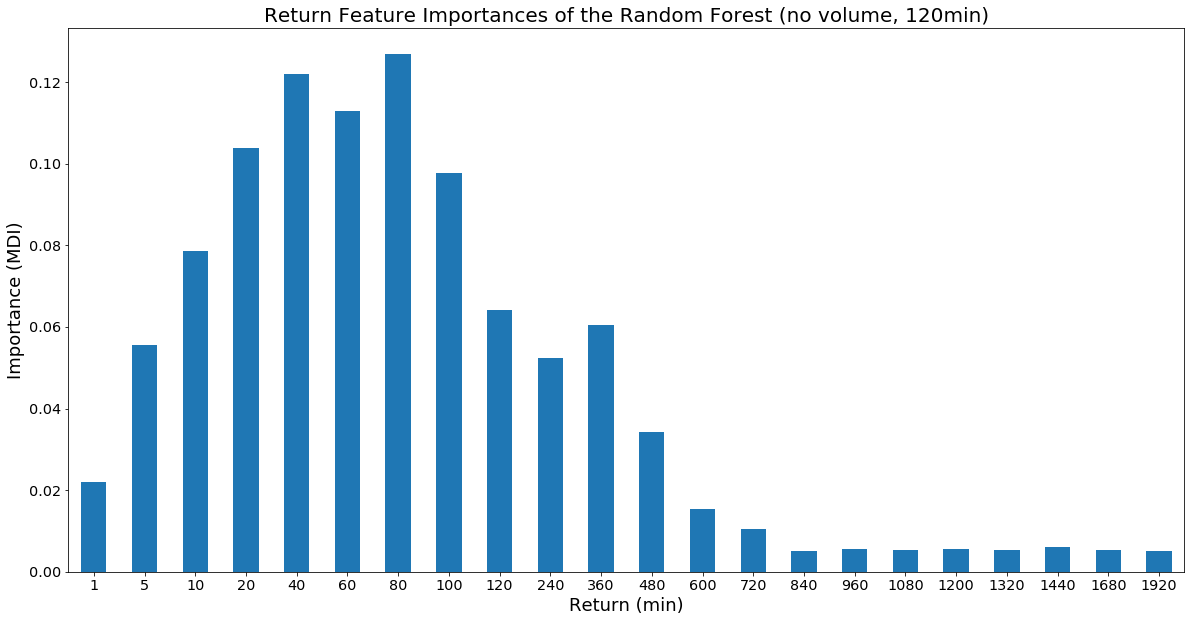

return with_volume future_2state_movement_120min


<Figure size 1080x360 with 0 Axes>

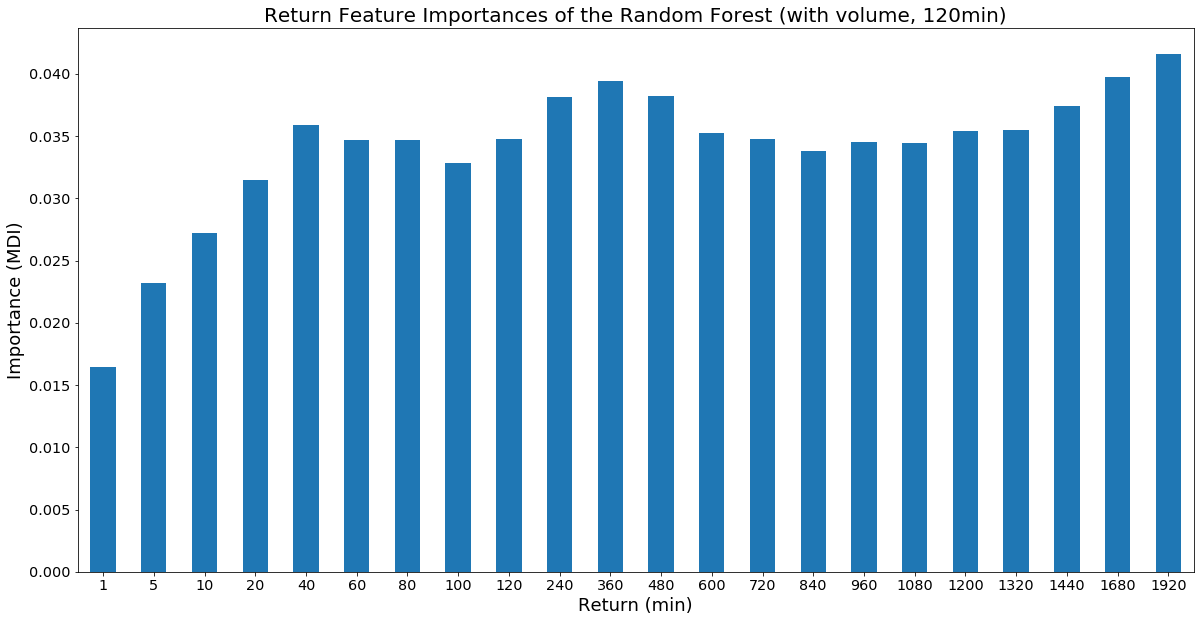

return no_volume future_2state_movement_240min


<Figure size 1080x360 with 0 Axes>

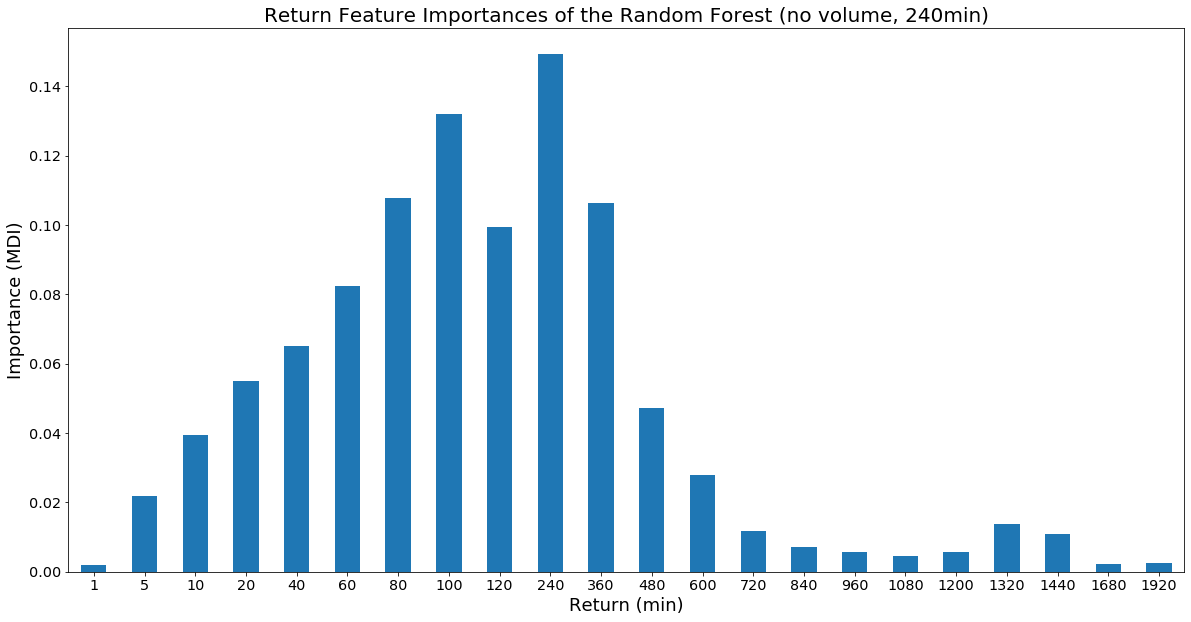

return with_volume future_2state_movement_240min


<Figure size 1080x360 with 0 Axes>

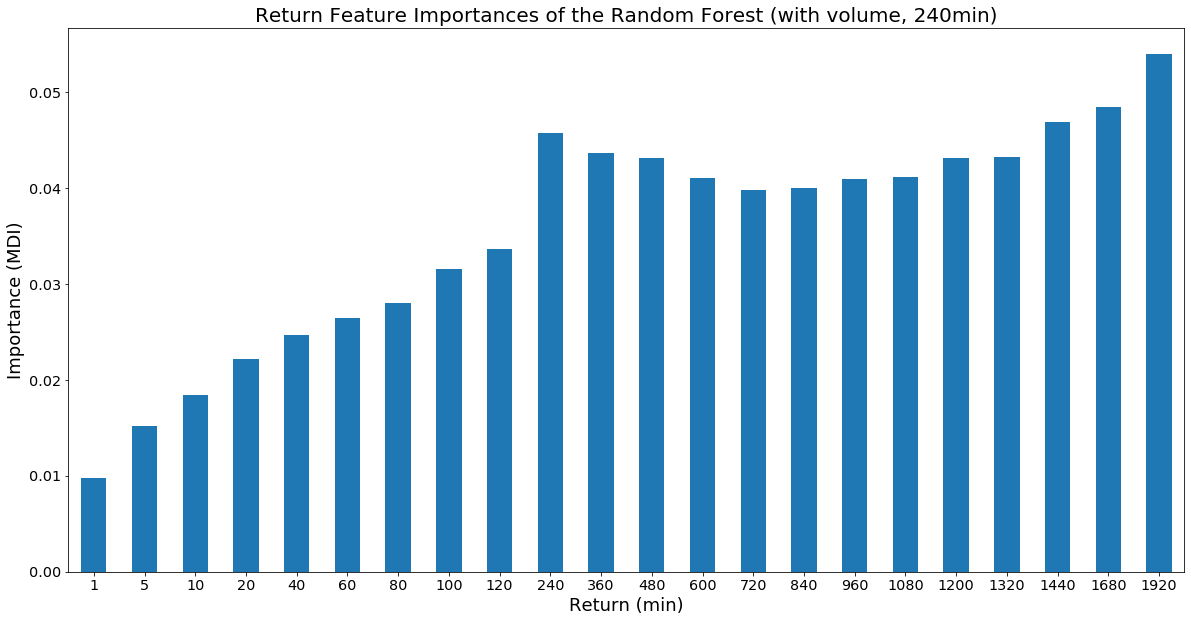

volume with_volume future_2state_movement_120min


<Figure size 1080x360 with 0 Axes>

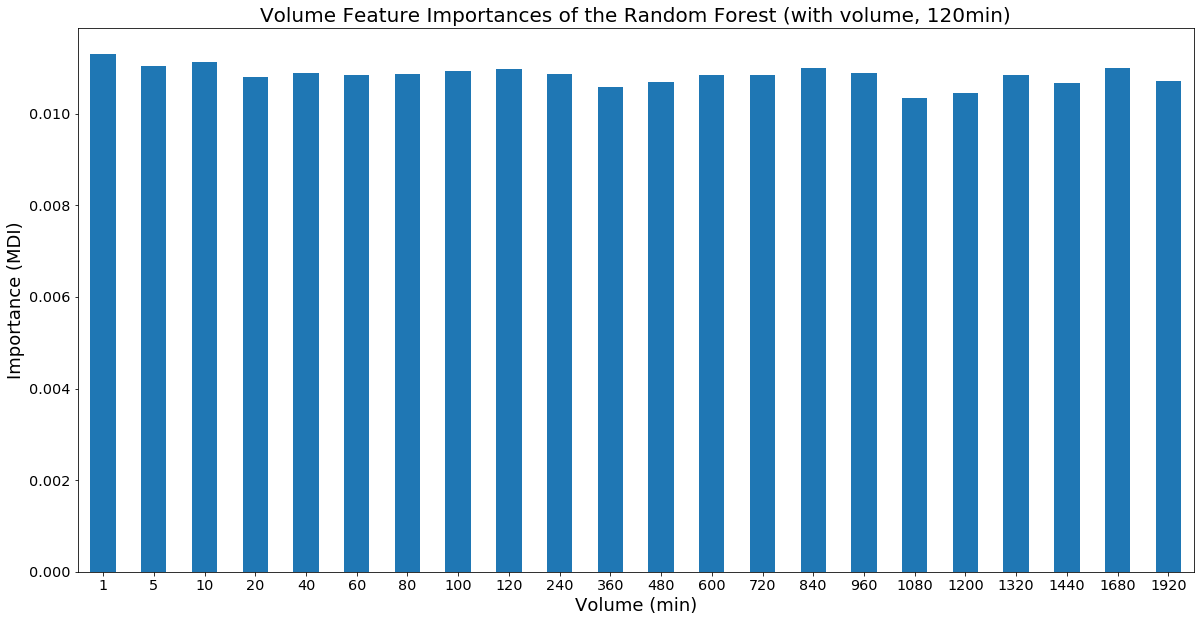

volume with_volume future_2state_movement_240min


<Figure size 1080x360 with 0 Axes>

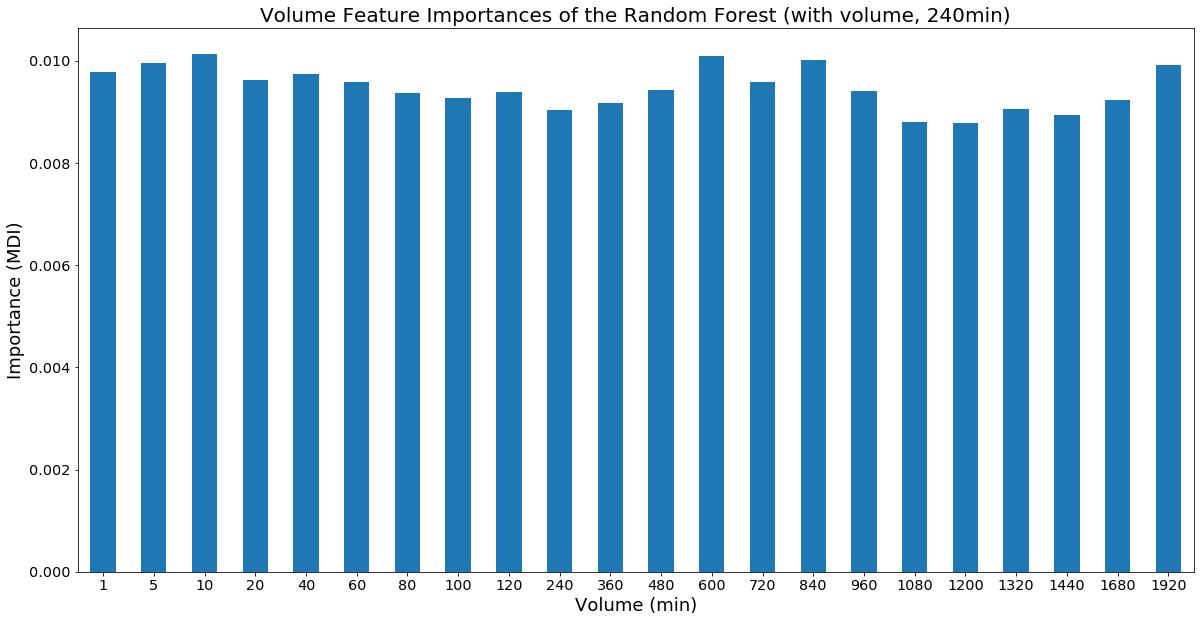

<Figure size 1080x360 with 0 Axes>

In [10]:
for feature_type in ["return", "volume"]:
    for target in targets_2state:     
        for volume_spec, columns in feature_selections.items():
            if not (feature_type == "volume" and volume_spec == "no_volume"):
                print(feature_type, volume_spec, target)
                clf = joblib.load(f"../models/forest/forest_{volume_spec}_{target}.pkl")
                x_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ][columns]
                y_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ][target] 

                feature_importances = pd.DataFrame(
                    {
                        'importance': clf.best_estimator_.steps[1][1].feature_importances_[:len(columns)], 
                        "feature": columns,
                    }
                ) 
                replace_string = "middle_return_" if feature_type == "return" else "volume_scaled_"
                feature_importances = feature_importances[ feature_importances["feature"].str.contains(replace_string) ]
        #         else:
        #             feature_importances = feature_importances[ feature_importances["feature"].str.contains("volume") ]
                
                feature_importances["feature"] = (
                    feature_importances["feature"]
                    .str.replace(replace_string, "")
                    .str.replace("min", "")
                    .astype(int)
                )
#                 fig = plt.figure()
                ax = (
                    feature_importances
                    .sort_values(by="feature")
                    .plot(
                        x="feature",
                        y="importance",
                        kind="bar",
                        figsize=(20,10),
                    )
                )
                ax.set_title(f"{feature_type.capitalize()} Feature Importances of the Random Forest ({volume_spec.replace('_', ' ')}, {target.replace('future_2state_movement_', '')})", fontsize=20)
                ax.set_xlabel(f"{feature_type.capitalize()} (min)", fontsize=18)
                ax.set_ylabel("Importance (MDI)", fontsize=18)
                ax.legend_ = None
                # ax.set_xticklabels("Lags", rotation=45)
                plt.xticks(rotation=0)
#                 plt.show()
                plt.savefig(f"../results/forest/plots/{feature_type}_feature_importance_{volume_spec}_{target}.png")
                plt.show()
                plt.clf()

## Regression Coefficients

return no_volume future_2state_movement_120min


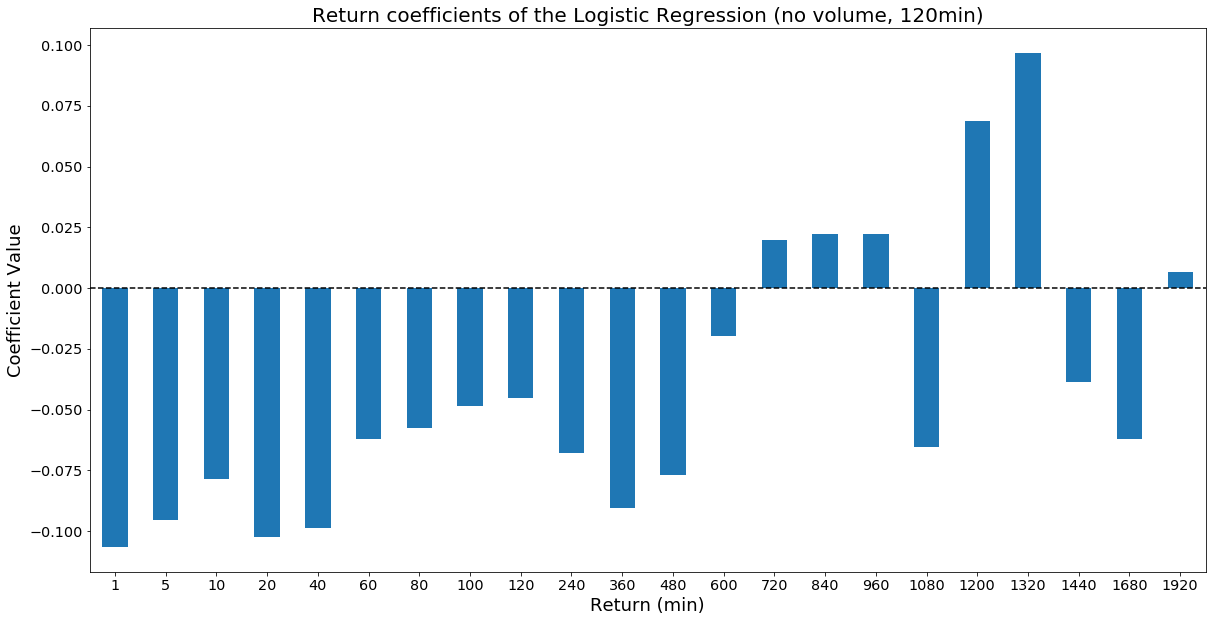

return with_volume future_2state_movement_120min


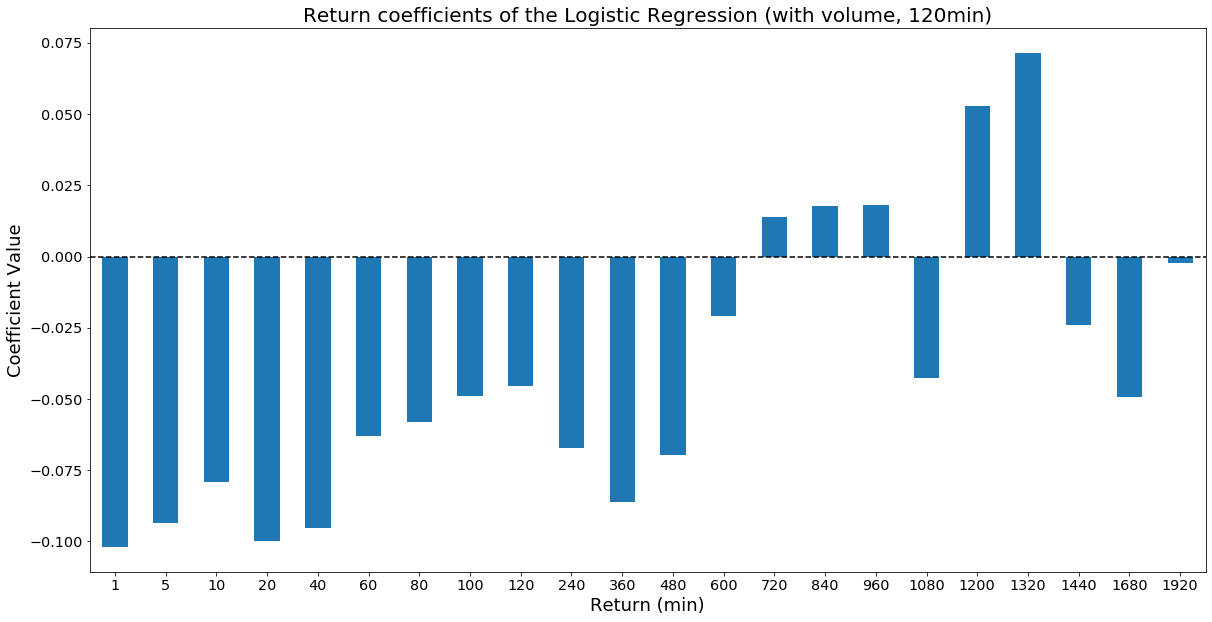

return no_volume future_2state_movement_240min


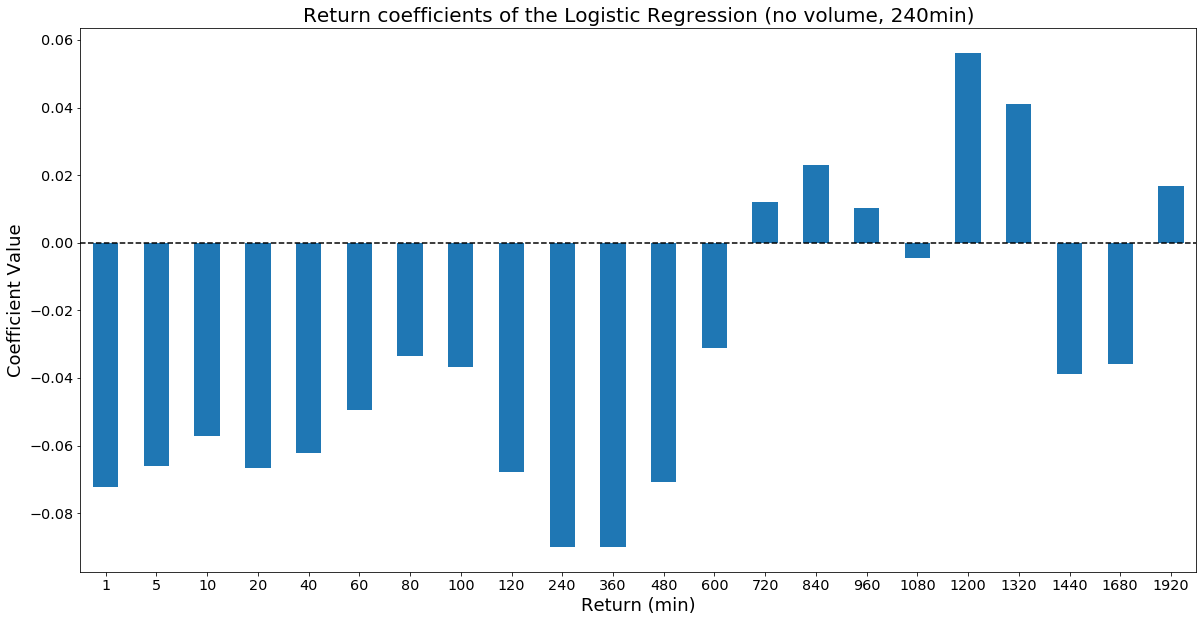

return with_volume future_2state_movement_240min


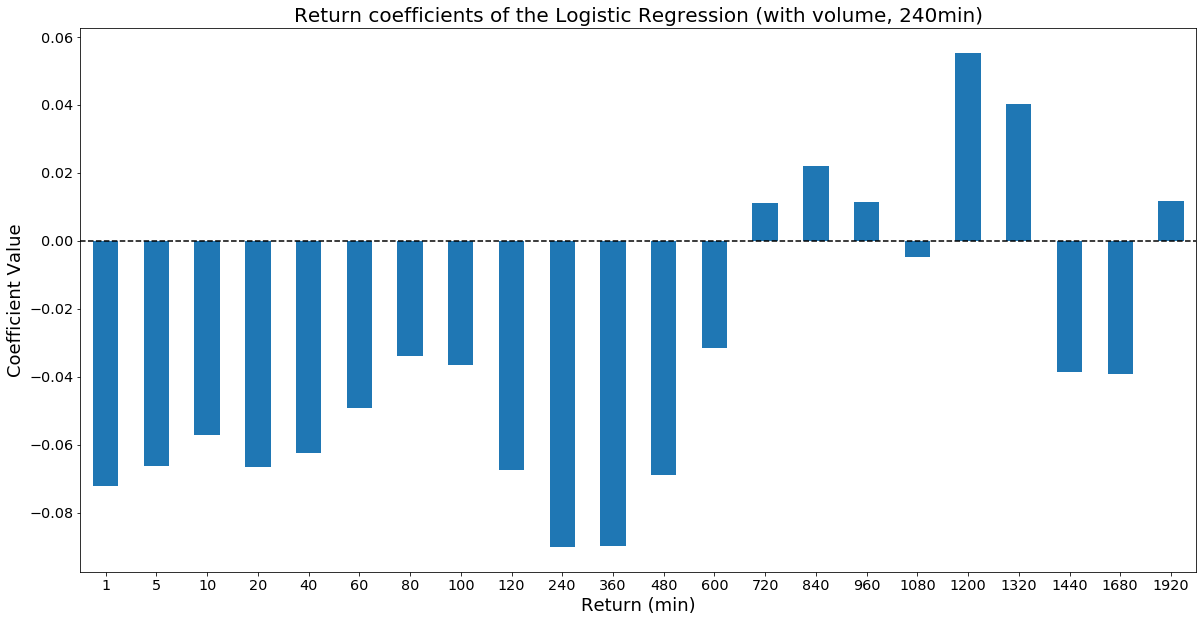

volume no_volume future_2state_movement_120min
volume with_volume future_2state_movement_120min


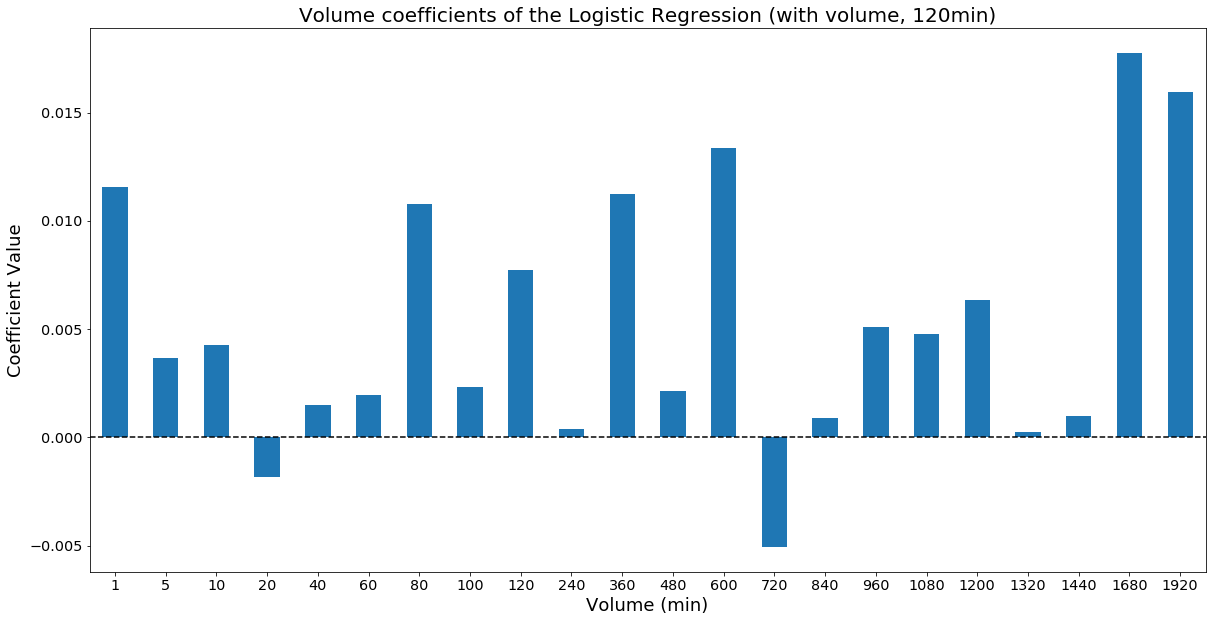

volume no_volume future_2state_movement_240min
volume with_volume future_2state_movement_240min


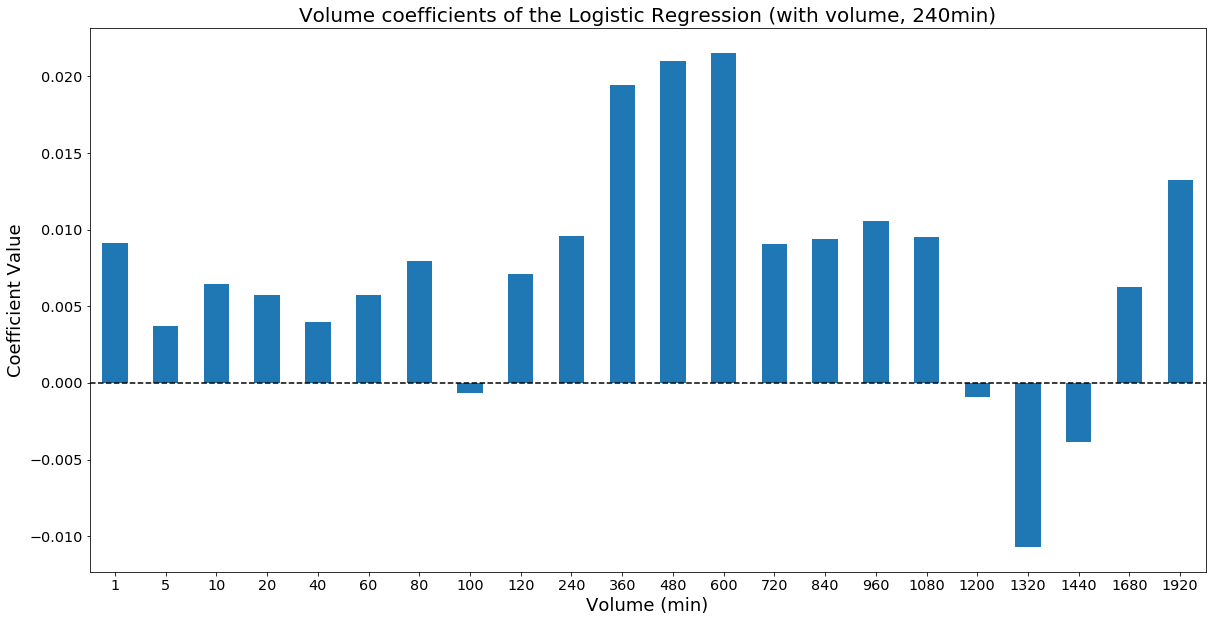

In [13]:
for feature_type in ["return", "volume"]:
    for target in targets_2state:     
        for volume_spec, columns in feature_selections.items():
            print(feature_type, volume_spec, target)
            if not (feature_type == "volume" and volume_spec == "no_volume"):
                x_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ][columns]
                y_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ][target] 
                x_train = filtered_1min_df[ (filtered_1min_df["time"] < "2019-11-01") ][columns]
                y_train = filtered_1min_df[ (filtered_1min_df["time"] < "2019-11-01") ][target]         
                clf = joblib.load(f"../models/logistic/logistic_{volume_spec}_{target}.pkl")

                coefficients = clf.best_estimator_.steps[1][1].coef_[0]

                logistic_coefficients = pd.DataFrame(
                    {
                        'coefficients': coefficients, 
                        "feature": columns,
                    }
                )  

                replace_string = "middle_return_" if feature_type == "return" else "volume_scaled_"
                logistic_coefficients = logistic_coefficients[ logistic_coefficients["feature"].str.contains(replace_string) ]

                logistic_coefficients["feature"] = (
                    logistic_coefficients["feature"]
                    .str.replace(replace_string, "")
                    .str.replace("min", "")
                    .astype(int)
                )            
                ax = (
                    logistic_coefficients
                    .sort_values(by="feature")
                    .plot(
                        x="feature",
                        y="coefficients",
                        kind="bar",
                        figsize=(20,10),
                    )
                )        

                ax.set_title(f"{feature_type.capitalize()} coefficients of the Logistic Regression ({volume_spec.replace('_', ' ')}, {target.replace('future_2state_movement_', '')})", fontsize=20)
                ax.set_xlabel(f"{feature_type.capitalize()} (min)", fontsize=18)
                ax.set_ylabel("Coefficient Value", fontsize=18)
                ax.legend_ = None
                # ax.set_xticklabels("Lags", rotation=45)
                ax.axhline(y=0, color='black', linestyle='--')
                plt.xticks(rotation=0)        
#                 plt.show()
                plt.savefig(f"../results/logistic/plots/{feature_type}_coefficients_{volume_spec}_{target}.png")
                plt.show()

In [ ]:
logistic_coefficients

In [ ]:
volume_columns = feature_selections["with_volume"][2::2]

In [ ]:
params = np.append(clf_logistic.best_estimator_.steps[1][1].intercept_, clf_logistic.best_estimator_.steps[1][1].coef_)
predictions = clf_logistic.predict(x_train)

In [ ]:
newX = x_train
newX["Constant"] = np.ones(x_train.shape[0])
MSE = (
    sum( (y_train["future_2state_movement_120min"].to_numpy() - predictions)**2 )
    / ( newX.shape[0]-len(newX.columns) ) 
)

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame(index = ["costant"] + [ int( col.replace("middle_return_", "").replace("min","").capitalize() ) for col in x_columns ],)
myDF3.index.name = "Delta (min)"
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
myDF3 = myDF3[1:]
myDF3

In [ ]:
myDF3['colors'] = 'b'
myDF3.loc[myDF3["t values"] >=1.96,'colors'] = 'r'
myDF3

In [ ]:
ax = (
    myDF3
#     myDF3
    .plot(
        kind="bar",
        figsize=(20,10),
        y="Coefficients",
        color=myDF3.colors,
    )
)

ax.set_title("Coefficients of the Logistic Regression for each lagged return", fontsize=20)
ax.set_xlabel("Return Delta (min)", fontsize=18)
ax.set_ylabel("Coefficient Value", fontsize=18)
ax.legend_ = None
# ax.set_xticklabels("Lags", rotation=45)
ax.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=0)
plt.savefig("../results/logistic/logistic_coefficients.png")

## Coin based Models

### Returns

In [8]:
# alt_targets = ["future_return_sign_120min", "future_return_sign_240min"]
alt_targets = {"future_return_sign_120min": "120min", "future_return_sign_240min": "240min"}
trading_returns_df = pd.DataFrame()
for model_name in model_names:
    for threshold in THRESHOLDS:
#         for volume_spec in ["with_volume", "no_volume"]:
        for volume_spec in feature_selections:
            for target, duration in alt_targets.items():
                try:
                    filename = f"../results/alternative/{model_name}/returns/trading_returns_{volume_spec}_{target}_{round(threshold*100, 1)}_threshold.csv"
                    df = pd.read_csv(filename)
                    df["volume_spec"] = volume_spec
                    df["threshold"] = threshold
                    df["model"] = model_name
                    df["target"] = target
                    trading_returns_df = pd.concat([trading_returns_df, df])
                    
                    print(model_name, threshold, volume_spec, target)
                except:
                    print("EXCEPTION:", filename)
#     trading_returns_df.to_csv(f"../results/{model_name}/returns/{model_name}_trading_returns_future_2state_movement.csv", index=False)
trading_returns_df.head()    
# trading_returns_df.to_csv(f"../results/trading_returns_future_2state_movement_120min.csv", index=False)        

logistic 0.5 no_volume future_return_sign_120min
logistic 0.5 no_volume future_return_sign_240min
logistic 0.5 with_volume future_return_sign_120min
logistic 0.5 with_volume future_return_sign_240min
logistic 0.525 no_volume future_return_sign_120min
logistic 0.525 no_volume future_return_sign_240min
logistic 0.525 with_volume future_return_sign_120min
logistic 0.525 with_volume future_return_sign_240min
logistic 0.55 no_volume future_return_sign_120min
logistic 0.55 no_volume future_return_sign_240min
logistic 0.55 with_volume future_return_sign_120min
logistic 0.55 with_volume future_return_sign_240min
logistic 0.575 no_volume future_return_sign_120min
logistic 0.575 no_volume future_return_sign_240min
logistic 0.575 with_volume future_return_sign_120min
logistic 0.575 with_volume future_return_sign_240min
logistic 0.6 no_volume future_return_sign_120min
logistic 0.6 no_volume future_return_sign_240min
logistic 0.6 with_volume future_return_sign_120min
logistic 0.6 with_volume future

adaboost 0.5 no_volume future_return_sign_120min
adaboost 0.5 no_volume future_return_sign_240min
adaboost 0.5 with_volume future_return_sign_120min
adaboost 0.5 with_volume future_return_sign_240min
adaboost 0.525 no_volume future_return_sign_120min
adaboost 0.525 no_volume future_return_sign_240min
adaboost 0.525 with_volume future_return_sign_120min
adaboost 0.525 with_volume future_return_sign_240min
adaboost 0.55 no_volume future_return_sign_120min
adaboost 0.55 no_volume future_return_sign_240min
adaboost 0.55 with_volume future_return_sign_120min
adaboost 0.55 with_volume future_return_sign_240min
adaboost 0.575 no_volume future_return_sign_120min
adaboost 0.575 no_volume future_return_sign_240min
adaboost 0.575 with_volume future_return_sign_120min
adaboost 0.575 with_volume future_return_sign_240min
adaboost 0.6 no_volume future_return_sign_120min
adaboost 0.6 no_volume future_return_sign_240min
adaboost 0.6 with_volume future_return_sign_120min
adaboost 0.6 with_volume future

,position_num,type,pair,open_row_num,open_time,open_price,duration,close_row_num,close_time,close_price,close_return,transaction_cost,volume_spec,threshold,model,target
0,1,long,btcusd,2,2019-11-01 00:02:00,9150.465671,120,122,2019-11-01 02:02:00,9161.00000,0.001151,0,no_volume,0.5,logistic,future_return_sign_120min
1,1,long,xrpusd,124,2019-11-01 02:04:00,0.294550,120,244,2019-11-01 04:04:00,0.29537,0.002784,0,no_volume,0.5,logistic,future_return_sign_120min
2,1,long,xmrusd,254,2019-11-01 04:14:00,58.954000,121,375,2019-11-01 06:15:00,58.89800,-0.000950,0,no_volume,0.5,logistic,future_return_sign_120min
3,1,long,dshusd,383,2019-11-01 06:23:00,71.379000,128,511,2019-11-01 08:31:00,71.29050,-0.001240,0,no_volume,0.5,logistic,future_return_sign_120min
4,1,long,babusd,519,2019-11-01 08:39:00,281.000000,360,879,2019-11-01 14:39:00,276.51500,-0.015961,0,no_volume,0.5,logistic,future_return_sign_120min


In [9]:
costs_bps = [ x*0.0005 for x in range(0, 5) ]
# get growth rate for all bps
for cost in costs_bps:
    trading_returns_df[f"return_growth_rate_{ int( cost * 10**4 ) }bps"] = np.where(
        trading_returns_df["type"] == "long",
        (trading_returns_df["close_price"] / trading_returns_df["open_price"]) * (1 - cost) / (1 + cost),
        (trading_returns_df["open_price"] / trading_returns_df["close_price"]) * (1 - cost) / (1 + cost),
    )
print(trading_returns_df.shape)    
trading_returns_df.head()    

(1567880, 21)


,position_num,type,pair,open_row_num,open_time,open_price,duration,close_row_num,close_time,close_price,...,transaction_cost,volume_spec,threshold,model,target,return_growth_rate_0bps,return_growth_rate_5bps,return_growth_rate_10bps,return_growth_rate_15bps,return_growth_rate_20bps
0,1,long,btcusd,2,2019-11-01 00:02:00,9150.465671,120,122,2019-11-01 02:02:00,9161.00000,...,0,no_volume,0.5,logistic,future_return_sign_120min,1.001151,1.000151,0.999151,0.998152,0.997155
1,1,long,xrpusd,124,2019-11-01 02:04:00,0.294550,120,244,2019-11-01 04:04:00,0.29537,...,0,no_volume,0.5,logistic,future_return_sign_120min,1.002784,1.001782,1.000780,0.999780,0.998781
2,1,long,xmrusd,254,2019-11-01 04:14:00,58.954000,121,375,2019-11-01 06:15:00,58.89800,...,0,no_volume,0.5,logistic,future_return_sign_120min,0.999050,0.998052,0.997054,0.996057,0.995062
3,1,long,dshusd,383,2019-11-01 06:23:00,71.379000,128,511,2019-11-01 08:31:00,71.29050,...,0,no_volume,0.5,logistic,future_return_sign_120min,0.998760,0.997762,0.996765,0.995768,0.994773
4,1,long,babusd,519,2019-11-01 08:39:00,281.000000,360,879,2019-11-01 14:39:00,276.51500,...,0,no_volume,0.5,logistic,future_return_sign_120min,0.984039,0.983056,0.982073,0.981091,0.980111


In [10]:
trading_returns_df["model"].unique()

array(['logistic', 'forest', 'adaboost', 'ann'], dtype=object)

In [11]:
agg_returns_df = (
    (
        (   
            # get total return per individual trading simulation
            trading_returns_df
            .groupby(["model", "volume_spec", "target", "threshold", "position_num", "type" ])
            .agg(
                { f"return_growth_rate_{int( cost * 10**4 )}bps": "prod" for cost in costs_bps }
            )
            .reset_index()
        )
        # get mean return per position type
        .groupby(["model", "volume_spec", "target", "threshold", "type"])
        .agg(
                { f"return_growth_rate_{int( cost * 10**4 )}bps": "mean" for cost in costs_bps }
        )
        .reset_index()
    )
    # mean return per threshold
    .groupby(["model", "volume_spec", "target", "threshold",])
    .agg(
            **{ f"{int( cost * 10**4 )}bps": (f"return_growth_rate_{int( cost * 10**4 )}bps", "mean") for cost in costs_bps }
    )
    -1
).reset_index()
# print(agg_returns_df[ agg_returns_df["model"] == "forest" ]["open_time"].max())
agg_returns_df["target"] = agg_returns_df["target"].str.replace("future_2state_movement_", "")
agg_returns_df["volume_spec"] = agg_returns_df["volume_spec"].str.replace("_", " ")
agg_returns_df["model"] = agg_returns_df["model"].map(MODEL_NAMES)
agg_returns_df.head()

,model,volume_spec,target,threshold,0bps,5bps,10bps,15bps,20bps
0,AdaBoost,no volume,future_return_sign_120min,0.500,0.422660,-0.188043,-0.536556,-0.735459,-0.848985
1,AdaBoost,no volume,future_return_sign_120min,0.525,0.047180,-0.189609,-0.324076,-0.400529,-0.444092
2,AdaBoost,no volume,future_return_sign_120min,0.550,0.018871,-0.197584,-0.323893,-0.397685,-0.440883
3,AdaBoost,no volume,future_return_sign_120min,0.575,0.001132,0.000131,-0.000869,-0.001867,-0.002865
4,AdaBoost,no volume,future_return_sign_120min,0.600,0.001132,0.000131,-0.000869,-0.001867,-0.002865


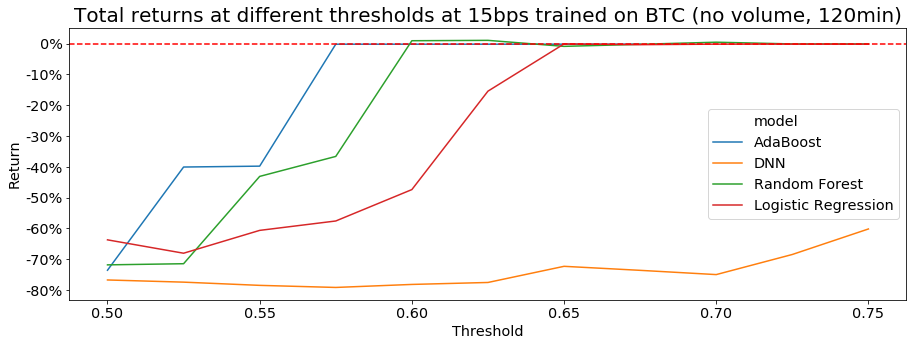

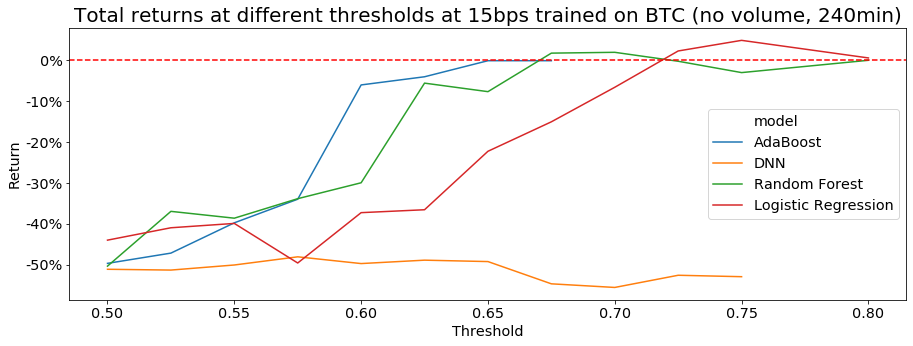

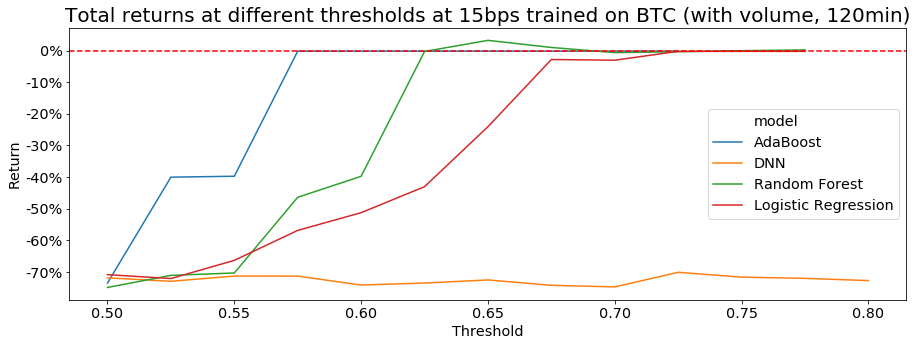

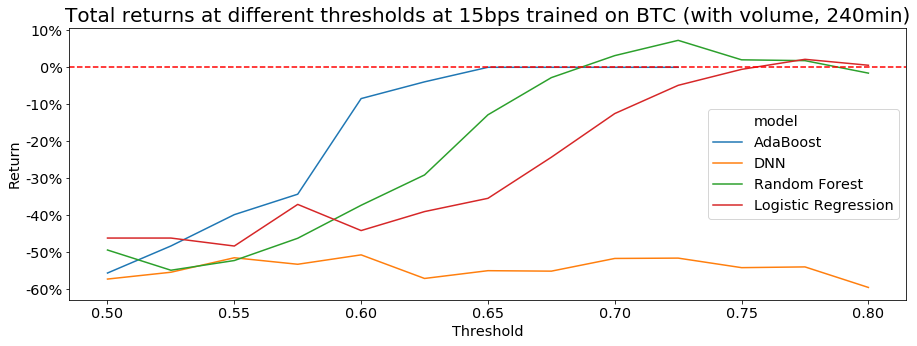

<Figure size 1080x360 with 0 Axes>

In [17]:
for volume_spec in agg_returns_df["volume_spec"].unique():
    for target, duration in alt_targets.items():
        df = agg_returns_df[ 
             (agg_returns_df["volume_spec"] == volume_spec) 
            & (agg_returns_df["target"] == target) 
        ]
        ax = sns.lineplot(x="threshold", y="15bps", hue="model", data=df)
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_title(f"Total returns at different thresholds at 15bps trained on BTC ({volume_spec}, {duration})")
        ax.set_ylabel("Return")
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
        ax.set_xlabel("Threshold")  
#         ax.set_xlim((0.5, 0.75))
        plt.show()
#         plt.draw()
#         plt.savefig(f"../results/alternative/btc_threshold_vs_return_15bps_{volume_spec}_{target}.png")
        plt.clf()

Notes:
- forest, with volume, 120min -> thresh: 0.75
- forest, with volume, 240min -> thresh: 0.75
- dnn, with volume, 120min -> thresh: 0.75
- dnn , with volume, 120min -> thresh: 0.75

### Accuracy

In [18]:
ALT_TARGETS = ["future_return_sign_120min", "future_return_sign_240min"]
top10_1min_df['future_return_sign_120min'] = np.sign(top10_1min_df['future_return_120min_constraint'])
top10_1min_df['future_return_sign_240min'] = np.sign(top10_1min_df['future_return_240min_constraint'])

filtered_1min_df = (
    top10_1min_df
    [ top10_1min_df[ f"volume_scaled"].shift(-1) != 0 ]
    .dropna()
)

c:\users\rared\appdata\local\programs\python\python37\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
filtered_1min_df.columns

Index(['Unnamed: 0', 'time', 'open', 'close', 'high', 'low', 'volume',
       'middle_median', 'pair', 'volume_scaled', 'middle_return_5min',
       'volume_scaled_5min', 'middle_return_10min', 'volume_scaled_10min',
       'middle_return_20min', 'volume_scaled_20min', 'middle_return_40min',
       'volume_scaled_40min', 'middle_return_60min', 'volume_scaled_60min',
       'middle_return_80min', 'volume_scaled_80min', 'middle_return_100min',
       'volume_scaled_100min', 'middle_return_120min', 'volume_scaled_120min',
       'middle_return_240min', 'volume_scaled_240min', 'middle_return_360min',
       'volume_scaled_360min', 'middle_return_480min', 'volume_scaled_480min',
       'middle_return_600min', 'volume_scaled_600min', 'middle_return_720min',
       'volume_scaled_720min', 'middle_return_840min', 'volume_scaled_840min',
       'middle_return_960min', 'volume_scaled_960min', 'middle_return_1080min',
       'volume_scaled_1080min', 'middle_return_1200min',
       'volume_scaled_

In [31]:
set(feature_selections["with_volume"]) - set(filtered_1min_df.columns)

set()

In [28]:
filtered_1min_df[feature_selections["with_volume"]]

,volume_scaled,middle_return_5min,volume_scaled_5min,middle_return_10min,volume_scaled_10min,middle_return_20min,volume_scaled_20min,middle_return_40min,volume_scaled_40min,middle_return_60min,...,middle_return_1320min,volume_scaled_1320min,middle_return_1440min,volume_scaled_1440min,middle_return_1680min,volume_scaled_1680min,middle_return_1920min,volume_scaled_1920min,middle_return_1min,volume_scaled_1min
1920,0.489633,0.000263,0.557690,0.000523,0.691986,-0.001260,0.986940,-0.003377,0.495302,-0.004098,...,0.016195,0.713396,0.023149,0.513022,0.027520,0.680862,0.025708,0.153225,-0.000025,0.213029
1921,0.092626,0.000178,0.222179,0.000612,0.421747,-0.000560,0.810159,-0.003554,0.347962,-0.004351,...,0.016349,0.588043,0.023109,0.097362,0.027596,0.681423,0.025399,0.971958,0.000013,0.489633
1922,0.737697,0.000217,0.378792,0.000556,0.934573,-0.000649,0.532970,-0.003618,0.411311,-0.004313,...,0.016579,0.448983,0.022952,0.214766,0.027385,0.703159,0.024791,0.854724,-0.000140,0.092626
1923,0.489843,0.000051,0.273906,0.000671,0.434424,-0.000408,0.562043,-0.003618,0.453981,-0.003770,...,0.017079,0.398652,0.023005,0.058099,0.027343,0.673464,0.023899,0.942818,0.000051,0.737697
1924,0.871862,0.000841,0.213029,0.001282,0.767614,-0.000025,0.176386,-0.002666,0.361211,-0.002653,...,0.018157,0.436945,0.023996,0.261860,0.028406,0.817439,0.024351,0.424673,0.000943,0.489843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255690,0.000000,0.000000,0.000000,-0.000648,0.000000,-0.002838,0.000000,-0.006964,0.000000,-0.009868,...,-0.017913,0.000000,-0.025235,0.000000,-0.050702,0.000000,-0.048142,0.000000,0.000000,0.000000
5255723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000961,0.000000,-0.009429,...,-0.021395,0.000000,-0.026263,0.000000,-0.049501,0.439032,-0.053039,0.000000,0.000000,0.000000
5255724,0.184155,0.000024,0.000000,0.000024,0.000000,0.000024,0.000000,-0.000937,0.000000,-0.009406,...,-0.021372,0.000000,-0.026239,0.000000,-0.049478,0.000000,-0.053016,0.000000,0.000024,0.000000
5255727,0.000000,0.000024,0.000000,0.000024,0.000000,0.000024,0.000000,-0.000937,0.000000,-0.005165,...,-0.021372,0.000000,-0.028366,0.000000,-0.049478,0.000000,-0.053016,0.000000,0.000000,0.000000


In [29]:
clf = joblib.load("../models/alternative/logistic/alternative_logistic_btcusd_with_volume_future_return_sign_120min.pkl")
# train
# accuracy scores

x_train = filtered_1min_df[ filtered_1min_df["time"] < "2019-11-01" ][feature_selections["with_volume"]]
y_train = filtered_1min_df[ filtered_1min_df["time"] < "2019-11-01" ]["future_return_sign_120min"]                        
# test
x_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ][feature_selections["with_volume"]]
y_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ]["future_return_sign_120min"] 

accuracy_train = clf.score( x_train, y_train)
accuracy_test = clf.score( x_test, y_test)
accuracy_scores.append({
"model": model_name,
"feature_selection": features_spec,
"target": target,
"accuracy_train": accuracy_train,
"accuracy_test": accuracy_test,                
})

ValueError: X does not have the same number of features as the previously fitted data. Got 45 instead of 22.

In [24]:
accuracy_scores = list()

for target in ALT_TARGETS:
    for features_spec, x_columns in feature_selections.items():  
        # train
        x_train = filtered_1min_df[ filtered_1min_df["time"] < "2019-11-01" ][x_columns]
        y_train = filtered_1min_df[ filtered_1min_df["time"] < "2019-11-01" ][target]                        
        # test
        x_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ][x_columns]
        y_test = filtered_1min_df[ (filtered_1min_df["time"] >= "2019-11-01") ][target]            
#         for model_name, model_fullname in {"ann": "Deep Neural Network"}.items():
        for model_name, model_fullname in MODEL_NAMES.items():
            file_name = f"alternative_{model_name}_btcusd_{features_spec}_{target}.pkl"
            file_path = f"../models/alternative/{model_name}/{file_name}"
            
            print(file_path)
            try:
                clf = joblib.load(file_path)
                # train
                # accuracy scores
                accuracy_train = clf.score( x_train, y_train)
                accuracy_test = clf.score( x_test, y_test)
                accuracy_scores.append({
                    "model": model_name,
                    "feature_selection": features_spec,
                    "target": target,
                    "accuracy_train": accuracy_train,
                    "accuracy_test": accuracy_test,                
                })
            except:
                print("EXCEPTION")
                
accuracy_scores

../models/alternative/forest/alternative_forest_btcusd_no_volume_future_return_sign_120min.pkl
../models/alternative/logistic/alternative_logistic_btcusd_no_volume_future_return_sign_120min.pkl
../models/alternative/adaboost/alternative_adaboost_btcusd_no_volume_future_return_sign_120min.pkl
../models/alternative/ann/alternative_ann_btcusd_no_volume_future_return_sign_120min.pkl
../models/alternative/forest/alternative_forest_btcusd_with_volume_future_return_sign_120min.pkl
EXCEPTION
../models/alternative/logistic/alternative_logistic_btcusd_with_volume_future_return_sign_120min.pkl
EXCEPTION
../models/alternative/adaboost/alternative_adaboost_btcusd_with_volume_future_return_sign_120min.pkl
EXCEPTION
../models/alternative/ann/alternative_ann_btcusd_with_volume_future_return_sign_120min.pkl
EXCEPTION
../models/alternative/forest/alternative_forest_btcusd_no_volume_future_return_sign_240min.pkl
../models/alternative/logistic/alternative_logistic_btcusd_no_volume_future_return_sign_240mi

[{'model': 'forest',
  'feature_selection': 'no_volume',
  'target': 'future_return_sign_120min',
  'accuracy_train': 0.5487062768630995,
  'accuracy_test': 0.5358592796092796},
 {'model': 'logistic',
  'feature_selection': 'no_volume',
  'target': 'future_return_sign_120min',
  'accuracy_train': 0.5491174153170546,
  'accuracy_test': 0.5370777370777371},
 {'model': 'adaboost',
  'feature_selection': 'no_volume',
  'target': 'future_return_sign_120min',
  'accuracy_train': 0.5417072141542161,
  'accuracy_test': 0.5297746235246236},
 {'model': 'ann',
  'feature_selection': 'no_volume',
  'target': 'future_return_sign_120min',
  'accuracy_train': 0.5597129125854672,
  'accuracy_test': 0.536513024013024},
 {'model': 'forest',
  'feature_selection': 'no_volume',
  'target': 'future_return_sign_240min',
  'accuracy_train': 0.5588364893779897,
  'accuracy_test': 0.5226139601139601},
 {'model': 'logistic',
  'feature_selection': 'no_volume',
  'target': 'future_return_sign_240min',
  'accurac